## Visualization with Python {#tutorial_vis_python}

This tutorial shows you how to load 3D volume data in Python and visualize it
using `matplotlib`.

First, you need access to the `spectre` Python bindings. A simple way to do this
is to run a Jupyter server from the build directory:

```sh
./bin/python-spectre -m jupyterlab
```

You can find detailed instruction in the tutorial on \ref spectre_using_python.

> Note for VSCode users: You can also select this Jupyter server as kernel for
> notebooks running in VSCode (see [docs](https://code.visualstudio.com/docs/datascience/jupyter-notebooks#_connect-to-a-remote-jupyter-server)).

Now we can import modules from the `spectre` Python package.

In [1]:
# Distributed under the MIT License.
# See LICENSE.txt for details.

import matplotlib.pyplot as plt
import numpy as np
import os

plt.style.use("../Examples/plots.mplstyle")

## Select an observation

First, we open the H5 volume data files from a simulation and get a list of all
available observations and their times:

In [18]:
from spectre.Visualization.OpenVolfiles import open_volfiles
from spectre.Visualization.ReadH5 import list_observations
import glob

h5files = glob.glob(
    # Point this to your volume data files
    "BbhVolume*.h5"
)
subfile_name = "/VolumeData"
obs_ids, obs_times = list_observations(open_volfiles(h5files, subfile_name))

We can also list all available variables in the volume data files:

In [21]:
import rich.columns

for volfile in open_volfiles(h5files, subfile_name, obs_ids[-1]):
    all_vars = volfile.list_tensor_components(obs_ids[-1])
    # Only look into the first file. The other should have the same variables.
    break

rich.print(rich.columns.Columns(all_vars))

ConformalFactor                 ExtrinsicCurvature_xx           ExtrinsicCurvature_yx          
ExtrinsicCurvature_yy           ExtrinsicCurvature_zx           ExtrinsicCurvature_zy          
ExtrinsicCurvature_zz           InertialCoordinates_x           InertialCoordinates_y          
InertialCoordinates_z           Lapse                           RadiallyCompressedCoordinates_x
RadiallyCompressedCoordinates_y RadiallyCompressedCoordinates_z ShiftExcess_x                  
ShiftExcess_y                   ShiftExcess_z                   Shift_x                        
Shift_y                         Shift_z                         SpatialMetric_xx               
SpatialMetric_yx                SpatialMetric_yy                SpatialMetric_zx               
SpatialMetric_zy                SpatialMetric_zz

### Interpolate to a slice

One way of visualizing your 3D volume data in a 2D plot is with a slice. Use
`interpolate_to_points` to interpolate your volume data to any set of
coordinates:

In [30]:
from spectre.IO.Exporter import interpolate_to_points

# Coordinates of a regular grid in the xy plane
x, y = np.meshgrid(np.linspace(-15, 15, 300), np.linspace(-15, 15, 300))
z = np.zeros(x.shape)

# Interpolation can be slow, so it's useful to cache the result. Remember to
# delete the cache file if you change anything.
cache_file = "interpolated_data.npy"
if os.path.isfile(cache_file):
    lapse = np.load(cache_file)
else:
    lapse = np.array(
        interpolate_to_points(
            h5files,
            subfile_name=subfile_name,
            observation_id=obs_ids[-1],
            tensor_components=["Lapse"],
            target_points=[x.flatten(), y.flatten(), z.flatten()],
        )
    ).reshape(x.shape)
    np.save(cache_file, lapse)

Now we can plot the 2D slice with `matplotlib`:

/var/folders/xp/5t2ny359187c4ljckf8sz3m80000gn/T/ipykernel_19858/3375439396.py:2: RuntimeWarning: invalid value encountered in subtract
  plt.contourf(x, y, np.log(1 - lapse))


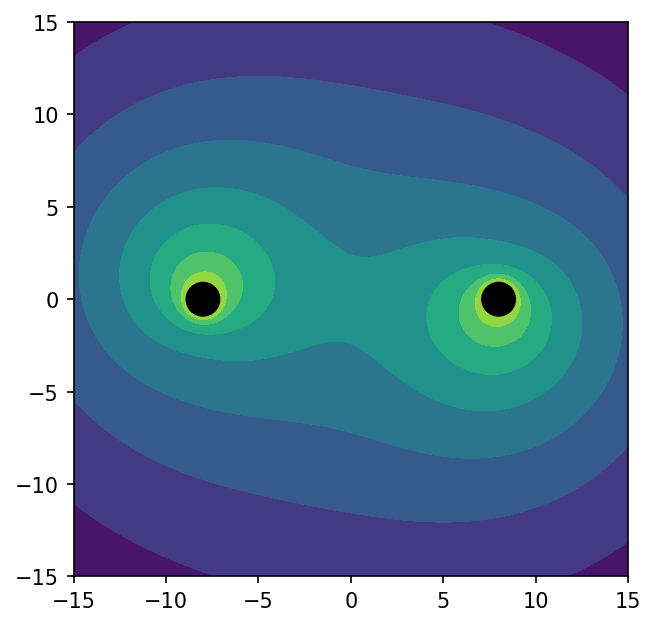

In [37]:
# Plot lapse
plt.contourf(x, y, np.log(1 - lapse))

# Plot circles for black holes
ax = plt.gca()
for bh_pos in [-8, 8]:
    ax.add_patch(
        plt.Circle(xy=(bh_pos, 0), radius=0.89, color="black", fill=True)
    )

# Make plot square
ax.set_aspect("equal")

### Plot individual elements

You can also iterate over elements in your volume data to plot things like
element boundaries, collocation points, etc. Use `iter_elements`:

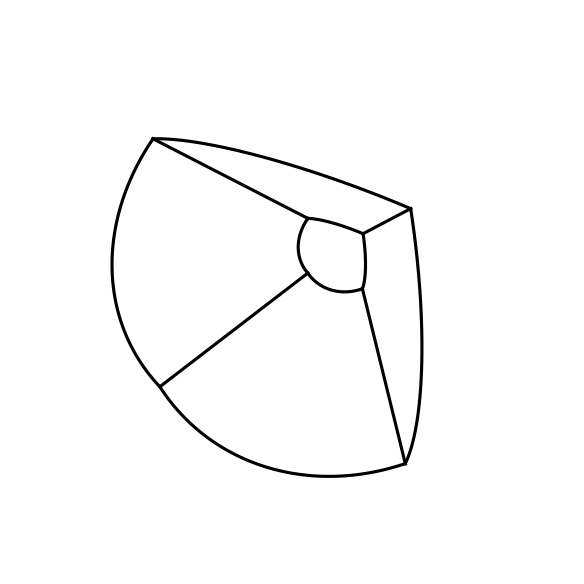

In [27]:
from spectre.IO.H5.IterElements import iter_elements

# Create a 3D plot
ax = plt.gcf().add_subplot(111, projection="3d")
ax.axis("off")

# Iterate over elements
for element in iter_elements(
    open_volfiles(h5files, subfile_name),
    obs_ids=obs_ids[0],
    element_patterns=["B3,*"],  # Only plot elements in block 3
):
    # Draw outline of the element by mapping the edges of the logical cube to
    # inertial coordinates using the element map
    for d in range(3):
        for edge in range(4):
            line = np.zeros((3, 100))
            line[d, :] = np.linspace(-1, 1, 100)
            line[(d + 1) % 3, :] = 2 * (edge % 2) - 1
            line[(d + 2) % 3, :] = 2 * (edge // 2) - 1
            x, y, z = element.map(line)
            ax.plot(x, y, z, color="black")

# Make plot square
ax.set_aspect("equal")